In [1]:
from openpilot.selfdrive.test.process_replay.process_replay import replay_process_with_name
from openpilot.selfdrive.car.ford.values import RADAR
from openpilot.tools.lib.logreader import LogReader


def run_radard_with_radar(identifier: str, radar: str) -> list:
  custom_params = {
    'RadarOverride': radar,
  }

  out = replay_process_with_name('radard', LogReader(identifier), custom_params=custom_params)

  rows = []
  t0 = None
  for m in out:
    if t0 is None:
      t0 = m.logMonoTime
    if m.which() != 'radarState':
      continue

    lead = m.radarState.leadOne
    if lead is None:
      continue
    rows.append(((m.logMonoTime - t0) / 1e9, lead.dRel, lead.yRel, lead.vRel, lead.aRel, lead.vLead, lead.dPath, lead.vLat))

  return rows


identifier = 'e886087f430e7fe7/00000001--8a3a859497/0:6'
msgs = {}
msgs[RADAR.CAMERA] = run_radard_with_radar(identifier, RADAR.CAMERA)
msgs[RADAR.DELPHI_MRR] = run_radard_with_radar(identifier, RADAR.DELPHI_MRR)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /mnt/c/Users/camer/AppData/Local/Programs/Microsoft VS Code
Using cached CarParams
VIN WF0NXXGCHNJR69712
{"event": "fingerprinted", "car_fingerprint": "FORD FOCUS 4TH GEN", "source": 1, "fuzzy": false, "cached": true, "fw_count": 11, "ecu_responses": [], "vin_rx_addr": -1, "vin_rx_bus": -1, "fingerprints": "{0: {145: 8, 146: 8, 1068: 8, 390: 8, 391: 8, 535: 8, 71: 8, 126: 8, 92: 8, 827: 8, 359: 8, 374: 8, 376: 8, 512: 8, 1072: 8, 120: 8, 517: 8, 604: 8, 970: 8, 980: 8, 1058: 8, 1059: 8, 578: 8, 73: 8, 119: 8, 125: 8, 516: 8, 531: 8, 130: 8, 532: 8, 534: 8, 972: 8, 1045: 8, 1126: 8, 1200: 8, 514: 8, 1122: 8, 1109: 8, 979: 8, 983: 8, 1010: 8, 1071: 8, 76: 8, 673: 8, 1047: 8, 1461: 8, 74: 8, 75: 8, 131: 8, 994: 8, 394: 8, 961: 8, 973: 8, 962: 8, 984: 8, 976: 8, 997: 8, 985: 8, 562: 8, 357: 8, 560: 8, 1044: 8, 1046: 8, 1108: 8, 1034: 8, 1073: 8, 1430: 8, 129: 8, 863: 8, 998: 8, 1056: 

In [4]:
import pandas as pd

columns = ['time', 'dRel', 'yRel', 'vRel', 'aRel', 'vLead', 'dPath', 'vLat']
df = None
for radar in (RADAR.CAMERA, RADAR.DELPHI_MRR):
  df_radar = pd.DataFrame(msgs[radar], columns=columns)
  df_radar['radar'] = radar
  df = pd.concat([df, df_radar]) if df is not None else df_radar

df.tail()

,time,dRel,yRel,vRel,aRel,vLead,dPath,vLat,radar
12047,361.430814,47.936604,-0.293088,0.218750,0.0,33.698856,0.0,0.0,FORD_CADS
12048,361.460484,47.936604,-0.293088,0.218750,0.0,33.684208,0.0,0.0,FORD_CADS
12049,361.491025,47.624870,0.110528,0.171875,0.0,33.633350,0.0,0.0,FORD_CADS
12050,361.521477,47.624870,0.110528,0.171875,0.0,33.630245,0.0,0.0,FORD_CADS
12051,361.550829,47.856819,-0.494446,0.171875,0.0,33.633553,0.0,0.0,FORD_CADS


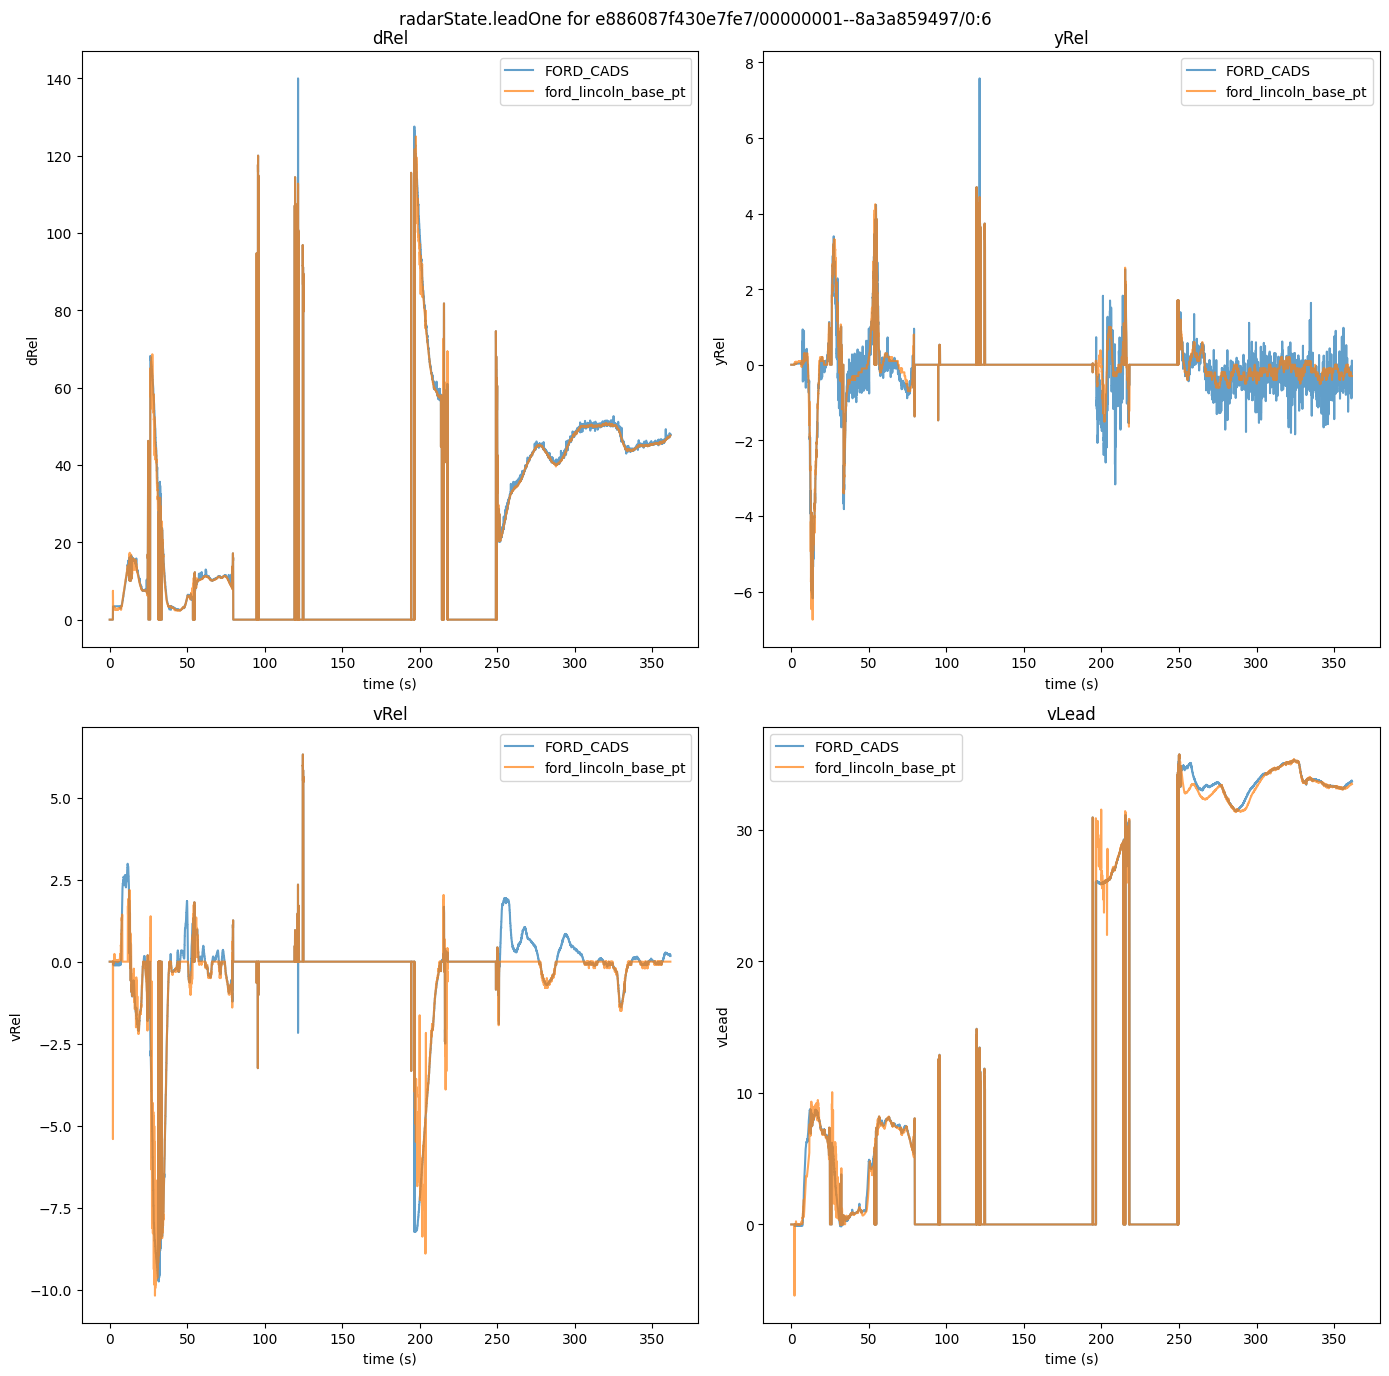

In [11]:
import matplotlib.pyplot as plt

plots = ['dRel', 'yRel', 'vRel', 'vLead']

fig, axs = plt.subplots(2, 2, figsize=(14, 14))
for i, col in enumerate(plots):
  ax = axs[i // 2, i % 2]
  for radar, data in df.groupby('radar'):
    data.plot(x='time', y=col, ax=ax, label=radar, alpha=0.7)
  ax.set_title(col)
  ax.set_xlabel('time (s)')
  ax.set_ylabel(col)
  ax.legend()

plt.suptitle(f'radarState.leadOne for {identifier}')
plt.tight_layout()
plt.show()